In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [12]:
d = pd.read_csv('data_000637.txt')
N = 15000
df = pd.DataFrame(d, index=range(N))
print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
14995     1     1            4  3869200316        3399         9
14996     1     1           17  3869200316        3400        15
14997     1     1           10  3869200316        3530        16
14998     1     1            8  3869200316        3533        18
14999     1     0          139  3869200316        3539         0

[15000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
#Find where the values changes
orbit_change = df["ORBIT_CNT"] != df["ORBIT_CNT"].shift(periods=-1)
#Compute the mean
df_mean = df[orbit_change].BX_COUNTER.mean()
print(df_mean)

3039.3197674418607


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [13]:
# create a new pd substracting in the ORBIT_CNT column the first row
orbit_change = df["ORBIT_CNT"] - df["ORBIT_CNT"].loc[0]

#Assume that the beginning of the data acquisition is the first row, so set the time starts at the first row from 0
#Compute the absolute number of ns
df["ABSOLUTE_TIME"] = orbit_change*df_mean*25 + df["BX_COUNTER"]*25 + df["TDC_MEAS"]
df["ABSOLUTE_TIME"] = df["ABSOLUTE_TIME"] - df["BX_COUNTER"].loc[0]*25 - df["TDC_MEAS"].loc[0]

#Convert to time series
df['ABSOLUTE_TIME'] = pd.to_datetime(df['ABSOLUTE_TIME'], unit='ns')

print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0         1     0          123  3869200167        2374        26   
1         1     0          124  3869200167        2374        27   
2         1     0           63  3869200167        2553        28   
3         1     0           64  3869200167        2558        19   
4         1     0           64  3869200167        2760        25   
...     ...   ...          ...         ...         ...       ...   
14995     1     1            4  3869200316        3399         9   
14996     1     1           17  3869200316        3400        15   
14997     1     1           10  3869200316        3530        16   
14998     1     1            8  3869200316        3533        18   
14999     1     0          139  3869200316        3539         0   

                      ABSOLUTE_TIME  
0     1970-01-01 00:00:00.000000000  
1     1970-01-01 00:00:00.000000001  
2     1970-01-01 00:00:00.000004477  
3     1970-01-01 00:00:00.00000

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
df['Time'] = pd.to_datetime(df['Time']).dt.time
print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0         1     0          123  3869200167        2374        26   
1         1     0          124  3869200167        2374        27   
2         1     0           63  3869200167        2553        28   
3         1     0           64  3869200167        2558        19   
4         1     0           64  3869200167        2760        25   
...     ...   ...          ...         ...         ...       ...   
14995     1     1            4  3869200316        3399         9   
14996     1     1           17  3869200316        3400        15   
14997     1     1           10  3869200316        3530        16   
14998     1     1            8  3869200316        3533        18   
14999     1     0          139  3869200316        3539         0   

                  Time  
0             00:00:00  
1             00:00:00  
2      00:00:00.000004  
3      00:00:00.000004  
4      00:00:00.000009  
...                ...  
14995  0

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
#create groups using GroupBy
g = df.groupby('TDC_CHANNEL')

#sorted the groups by number of items (most frequent first)
g_Sorted = g.size().sort_values(ascending=False)
#print( g.size().sort_values(ascending=False))

#take the first three tdc_channel values
target_values = g_Sorted.head(3).index
print(target_values)

Int64Index([139, 64, 63], dtype='int64', name='TDC_CHANNEL')


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [15]:
#print(df.loc[df["ORBIT_CNT"] == float("nan")])
orbit_change = df["ORBIT_CNT"] - df["ORBIT_CNT"].shift(periods=-1)
#print(orbit_change.loc[orbit_change >= 2])
# There are no missing ORBIT_CNT and no ORBIT_CNT has Nan values
num = abs(orbit_change.sum())
print(num)

149.0


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
#fix TDC_CHANNEL=139 and create groups by orbits
gk = df.loc[df["TDC_CHANNEL"]==139].groupby(['ORBIT_CNT'])

#print the number of the orbits
print(len(gk))

150


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
#create series with FPGA = 0 and set tdc channel as index
g1 = df.loc[df["FPGA"] == 0].groupby(['TDC_CHANNEL']).size()

#create series with FPGA = 1 and set tdc channel as index
g2 = df.loc[df["FPGA"] == 1].groupby(['TDC_CHANNEL']).size()
print(g1)
print(g2)

TDC_CHANNEL
1        8
2       16
3       16
4       19
5       19
      ... 
121     63
122     71
123    202
124    193
139    879
Length: 117, dtype: int64
TDC_CHANNEL
1      338
2      363
3      277
4      290
5      189
      ... 
125      6
126      7
127     16
128     18
139    389
Length: 124, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

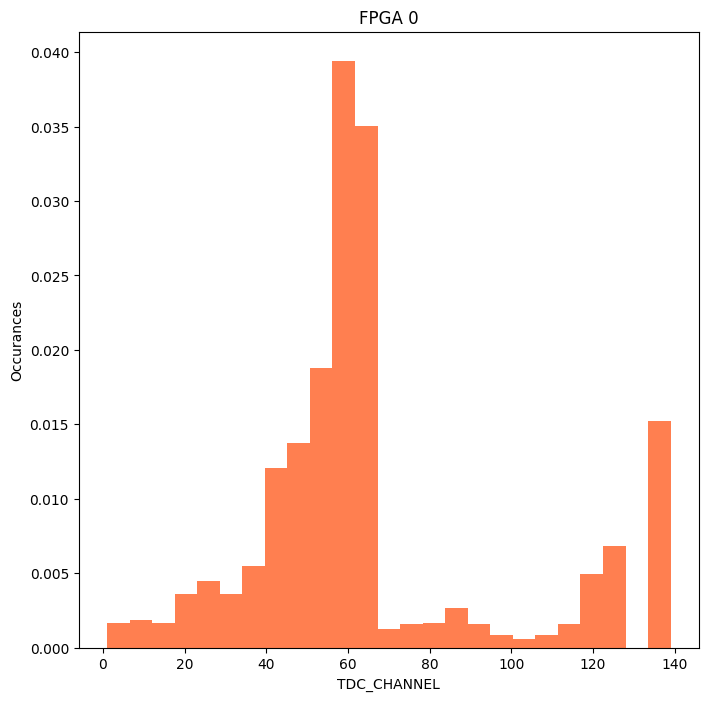

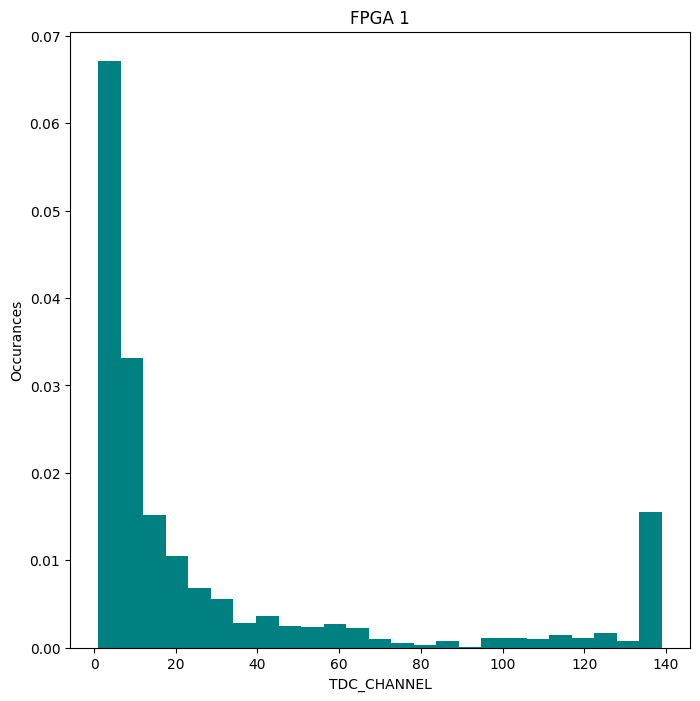

In [17]:
g1 = df.loc[df["FPGA"] == 0]
fig1 = plt.figure(num="Figure 1", figsize=(8, 8))
plt.hist(g1['TDC_CHANNEL'], bins=25, density=True, cumulative=False, color='coral')
plt.title('FPGA 0')
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Occurances")
plt.show()

g2 = df.loc[df["FPGA"] == 1]
fig2 = plt.figure(num="Figure 2", figsize=(8, 8))
plt.hist(g2['TDC_CHANNEL'], bins=25, density=True, cumulative=False, color='teal')
plt.title('FPGA 1')
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Occurances")
plt.show()